# freud.diffraction.StaticStructureFactor

The `freud.diffraction.StaticStructureFactor` class computes a one-dimensional [static structure factor](https://en.wikipedia.org/wiki/Structure_factor) $S(k)$ of a set of points.

In [1]:
import time
from contextlib import contextmanager

import freud
import matplotlib.pyplot as plt
import mdtraj
import numpy as np
import rowan
from scipy.integrate import simps
from tqdm.auto import tqdm

In [2]:
@contextmanager
def timer(name=None):
    start = time.perf_counter_ns()
    yield
    end = time.perf_counter_ns()
    title = f"{name} " if name else ""
    print(f"{title}Time: ", (end - start) / 1e9)

In [3]:
trj = mdtraj.load("chlorine-pos-1.xyz", top="chlorine_32.pdb")
L = 1.31302
trj.unitcell_lengths = np.full((trj.n_frames, 3), [L, L, L], dtype="float32")
A = np.full((trj.n_frames, 3, 3), [L, L, L], dtype="float32")
for i in range(trj.n_frames):
    A[i, :, :] = np.diag(np.diag(A[i, :, :]))
trj.unitcell_vectors = A
trj = trj[-50:]

In [4]:
print(np.min(trj.xyz[-500:], axis=(0, 1)))
print(np.max(trj.xyz[-500:], axis=(0, 1)))

[-0.5040643 -0.3791787 -0.6143455]
[1.2199415 1.2757446 1.2640504]


In [76]:
# box = freud.Box.cube(L)
# points = box.wrap(trj.xyz[-1])
# system = (box, points)
# system = freud.data.make_random_system(10, 2000)
fcc = freud.data.UnitCell.fcc()
box, points = fcc.generate_system(20, sigma_noise=0.1)
system = (box, points)
system = freud.AABBQuery.from_system(system)

In [53]:
L = np.min(system.box.L)
k_min_characteristic = 4 * np.pi / L
k_min = 0
k_max = 100
bins = 20001

In [54]:
4 * np.pi / L

0.8377580409572781

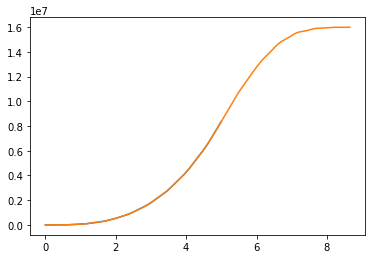

In [7]:
rij = system.box.compute_all_distances(system.points, system.points).flatten()
num_bins = int(2e4)
aco, au = np.histogram(rij, num_bins)
au = au[:-1] + (au[1] - au[0]) / 2
aco[0] = 0
# RDF Direct method
min_L = np.min(system.box.L)
r_max = np.nextafter(min_L / 2.0, 0.0, dtype=np.float32)
rdf = freud.density.RDF(int(2e4), r_max)
rdf.compute(system)
plt.plot(rdf.bin_centers, np.cumsum(rdf.bin_counts))
plt.plot(au, np.cumsum(aco))

In [75]:
def allen_method(system, bins, k_max, k_min, periodic):
    from scipy.spatial.distance import cdist

    system = freud.locality.NeighborQuery.from_system(system)
    pos = system.points
    N = len(system.points)

    # Compute interparticle distances
    if periodic:
        rij = system.box.compute_all_distances(system.points, system.points).flatten()
    else:
        box_temp = system.box
        box_temp.periodic = False
        system = freud.locality.NeighborQuery.from_system((box_temp, system.points))
        rij = system.box.compute_all_distances(system.points, system.points).flatten()

    # Histogram to save time
    # aco = counts at a particular distance, au = possible distances
    num_bins = int(2e4)
    aco, au = np.histogram(rij, num_bins)
    au = au[:-1] + (au[1] - au[0]) / 2
    au[0] = 1e-10
    del rij

    if False:
        min_L = np.min(system.box.L)
        aco = aco[au < min_L / 2]
        au = au[au < min_L / 2]

    # qs to examine
    qs = np.linspace(k_min, k_max, bins)
    sf = []

    # Intensities
    for it, q in enumerate(tqdm(qs)):
        sinq = np.sin(au * q) / au / q * aco
        aas = np.sum(sinq)
        sf.append(aas / N)

    sf = np.asarray(sf)
    return qs, sf

In [78]:
def kwang_method(system, nMax=36):
    def calCompDensity(qVec, partPosition):
        kDOTr = np.matmul(partPosition, qVec.transpose())
        expo_kDOTr = np.exp(-1j * kDOTr)
        numDensity = np.sum(expo_kDOTr)
        return numDensity

    current_box = system.box
    Lx = current_box.Lx
    Ly = current_box.Ly
    Lz = current_box.Lz
    minL = min(Lx, Ly, Lz)
    qbasis_x = 2 * np.pi / Lx
    qbasis_y = 2 * np.pi / Ly
    qbasis_z = 2 * np.pi / Lz

    positions = system.points

    # Prepare cubic reciprocal lattice.
    q_latPositions_integer_CUBE = []
    for nx in np.linspace(-nMax, nMax, nMax * 2 + 1, endpoint=True):
        for ny in np.linspace(-nMax, nMax, nMax * 2 + 1, endpoint=True):
            for nz in np.linspace(-nMax, nMax, nMax * 2 + 1, endpoint=True):
                if nx != 0 or ny != 0 or nz != 0:
                    q_latPositions_integer_CUBE.append([nx, ny, nz])

    q_latPositions_integer_CUBE = np.asarray(q_latPositions_integer_CUBE)

    aq = freud.AABBQuery(
        freud.Box(nMax * 2.5, nMax * 2.5, nMax * 2.5), np.asarray([[0.0, 0.0, 0.0]])
    )
    nlist = aq.query(q_latPositions_integer_CUBE, {"r_max": nMax}).toNeighborList()
    nl_index_j = np.copy(nlist.query_point_indices)

    # Within the cubic reciprocal lattice remove wavevectors positioned outside of the r_cut.

    q_latPositions_integer_SPHERE = []
    for jj in range(len(nl_index_j)):
        q_latPositions_integer_SPHERE.append(
            q_latPositions_integer_CUBE[nl_index_j[jj]]
        )
    q_latPositions_integer_SPHERE = np.asarray(q_latPositions_integer_SPHERE)

    # Remove redundant wavevectors for efficiency.

    # Note: (For 1D structure obtained by orientation averaging) half of the wave vectors are redundant
    # Suppose magnitude of reciprocal basis is q0. Suppose one like to measure 1D structure factor at q = q0.
    # One does not has to take all the wave vectors with magnitude of q0 [q0, 0, 0], [0, q0, 0], [0, 0, q0], [-q0, 0, 0], [0, -q0, 0], [0, 0, -q0] into account.
    # One only has to consider half of them [q0, 0, 0], [0, q0, 0], [0, 0, q0]. The remainder [-q0, 0, 0], [0, -q0, 0], [0, 0, -q0] are redundant.

    vector_NormalTo111Plane = np.array(
        [1.0 / np.sqrt(3.0), 1.0 / np.sqrt(3.0), 1.0 / np.sqrt(3.0)]
    )
    dotProdcut = np.matmul(
        q_latPositions_integer_SPHERE, vector_NormalTo111Plane.transpose()
    )

    q_latPositions_interger = []
    for jj in range(len(dotProdcut)):
        if dotProdcut[jj] >= 0.0:
            q_latPositions_interger.append(q_latPositions_integer_SPHERE[jj])
    q_latPositions = np.asarray(q_latPositions_interger) * qbasis_x

    # Find norm of wavevectors in the reciprocal lattice
    norm_q_latPositions = np.array([np.linalg.norm(v) for v in q_latPositions])

    # Calculate structure factor

    # Sort wavevectors by their norm and calculate structure factors
    qLength = []
    Sq = []

    for jj in range(1, nMax + 1):
        # Find wavevectors with (nearly) same magnitudes.
        curr_q = np.where(
            ((np.pi * 2.0 * jj / Lx - np.pi / Lx) <= norm_q_latPositions[:])
            & (norm_q_latPositions[:] < (np.pi * 2.0 * jj / Lx + np.pi / Lx))
        )[0]

        if len(curr_q) > 0:
            qLength.append(np.pi * 2.0 * jj / Lx)
            currSq = []
            for ci in range(len(curr_q)):
                compDen = calCompDensity(q_latPositions[curr_q[ci]], positions)
                currSq.append(compDen.real ** 2.0 + compDen.imag ** 2.0)
            currSq = np.array(currSq)

            # Append (orientation) average value of structure factor.
            Sq.append(np.average(currSq, axis=0) / len(positions))

    Sq = np.array(Sq)
    qLength = np.array(qLength)

    return qLength, Sq

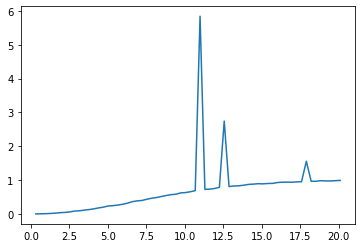

In [81]:
Q_kwang, S_kwang = kwang_method(system, nMax=64)
plt.plot(Q_kwang, S_kwang)

In [25]:
def validate_method(system, bins, k_max, k_min, direct):
    """Validation of the static structure calculation.

    This method is a pure Python reference implementation of the direct
    method implemented in C++ in freud.

    Args:
        system:
            Any object that is a valid argument to
            :class:`freud.locality.NeighborQuery.from_system`.
        bins (unsigned int):
            Number of bins in :math:`k` space.
        k_max (float):
            Maximum :math:`k` value to include in the calculation.
        k_min (float):
            Minimum :math:`k` value to include in the calculation.
        direct (bool):
            If ``True``, the structure factor is calculated by the *direct*
            method. If ``False``, the *RDF Fourier Transform* method is used.
    """
    system = freud.locality.NeighborQuery.from_system(system)
    N = len(system.points)

    Q = np.linspace(k_min, k_max, bins, endpoint=False)
    Q += (k_max - k_min) / bins / 2
    S = np.zeros_like(Q)

    if direct == "rdf":
        # RDF Direct method
        min_L = np.min(system.box.L)
        r_max = np.nextafter(min_L / 2.0, 0.0, dtype=np.float32)
        rdf = freud.density.RDF(int(2e4), r_max)
        rdf.compute(system)

        for i, q in enumerate(Q):
            S[i] = np.sum(rdf.bin_counts * np.sinc(q * rdf.bin_centers / np.pi)) / N

    elif direct:
        # Direct method

        # Compute all pairwise distances
        distances = system.box.compute_all_distances(
            system.points, system.points
        ).flatten()

        for i, q in enumerate(tqdm(Q)):
            S[i] = np.sum(np.sinc(q * distances / np.pi)) / N
    else:
        # RDF Fourier Transform method
        min_L = np.min(system.box.L)
        r_max = np.nextafter(min_L / 2.0, 0.0, dtype=np.float32)
        rdf = freud.density.RDF(int(2e4), r_max)
        rdf.compute(system)

        def integrate_rdf(rdf, q, i):
            r = rdf.bin_centers
            g_r = rdf.rdf
            integrand = r ** 2 * (g_r - 1) * np.sinc(q * r / np.pi)
            return simps(integrand, r)

        for i, q in enumerate(Q):
            rdf_integrated = integrate_rdf(rdf, q, i)
            S[i] = 1 + (4 * np.pi * N / system.box.volume) * rdf_integrated

    return Q, S


Time:  71.7600631


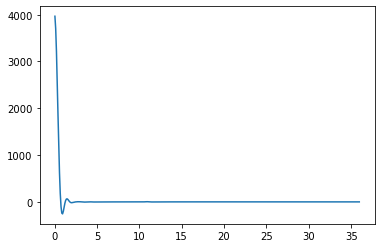

In [29]:
with timer():
    Q_direct, S_direct = validate_method(
        system, int(bins / 50), k_max=36, k_min=0, direct=True
    )
plt.plot(Q_direct, S_direct)
plt.show()

Time:  36.2777728


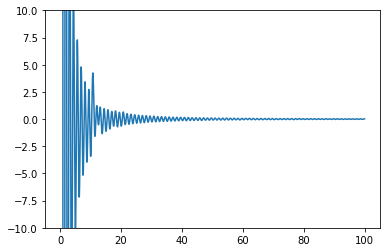

In [13]:
with timer():
    Q_rdf_direct, S_rdf_direct = validate_method(
        system, bins, k_max, k_min, direct="rdf"
    )
plt.plot(Q_rdf_direct, S_rdf_direct)
plt.ylim(-10, 10)
plt.show()

Time:  45.4673377


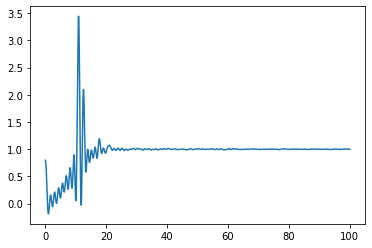

In [14]:
with timer():
    Q_rdf, S_rdf = validate_method(system, bins, k_max, k_min, direct=False)
plt.plot(Q_rdf, S_rdf)
plt.show()

In [15]:
with timer():
    sk_rdf = freud.diffraction.StaticStructureFactor(bins, k_max, k_min, False)
    sk_rdf.compute(system)

AttributeError: module 'freud.diffraction' has no attribute 'StaticStructureFactor'

In [ ]:
with timer():
    sk_direct = freud.diffraction.StaticStructureFactor(bins, k_max, k_min, True)
    sk_direct.compute(system)
    # 8.707971
    # 14.1775621

In [74]:
with timer():
    Q_allen2, S_allen2 = allen_method(system, bins, k_max, k_min, periodic=False)
with timer():
    Q_allen, S_allen = allen_method(system, bins, k_max, k_min, periodic=True)

> <ipython-input-73-ca2721ae0b5a>(21)allen_method()
     19     # Histogram to save time
     20     # aco = counts at a particular distance, au = possible distances
---> 21     num_bins = int(2e4)
     22     aco, au = np.histogram(rij, num_bins)
     23     au = au[:-1] + (au[1] - au[0]) / 2



ipdb>  rij


array([ 0.       ,  8.150544 ,  1.5251368, ..., 11.650098 ,  5.018781 ,
        0.       ], dtype=float32)


ipdb>  rij2


array([[ 0.        ,  8.15054406,  1.52513675, ...,  6.74422463,
         4.73880385,  8.38509627],
       [ 8.15054406,  0.        ,  7.28324014, ...,  3.92714965,
         6.84136231,  9.99587403],
       [ 1.52513675,  7.28324014,  0.        , ...,  5.39217233,
         5.20176614,  9.3314779 ],
       ...,
       [ 6.74422463,  3.92714965,  5.39217233, ...,  0.        ,
         7.19340249, 11.65009775],
       [ 4.73880385,  6.84136231,  5.20176614, ...,  7.19340249,
         0.        ,  5.01878126],
       [ 8.38509627,  9.99587403,  9.3314779 , ..., 11.65009775,
         5.01878126,  0.        ]])


ipdb>  max(rij)


16.424774


ipdb>  max(rij2)


*** ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


ipdb>  max(rij2.flatten())


16.42477292069357


ipdb>  rij2 = rij2.flatten()
ipdb>  (rij == rij2).sum()


2000


ipdb>  np.allclose(rij, rij2)


True


ipdb>  len(rij)


4000000


ipdb>  len(pos)


2000


ipdb>  c


<ipython-input-73-ca2721ae0b5a>:21: RuntimeWarning: invalid value encountered in true_divide
  num_bins = int(2e4)



Time:  89.5642736


<ipython-input-73-ca2721ae0b5a>:38: RuntimeWarning: invalid value encountered in true_divide
  sinq = np.sin(au * q) / au / q * aco



Time:  2.672996


In [17]:
# sk_direct.S_k - S_direct

In [18]:
sk_rdf.S_k - S_rdf

NameError: name 'sk_rdf' is not defined

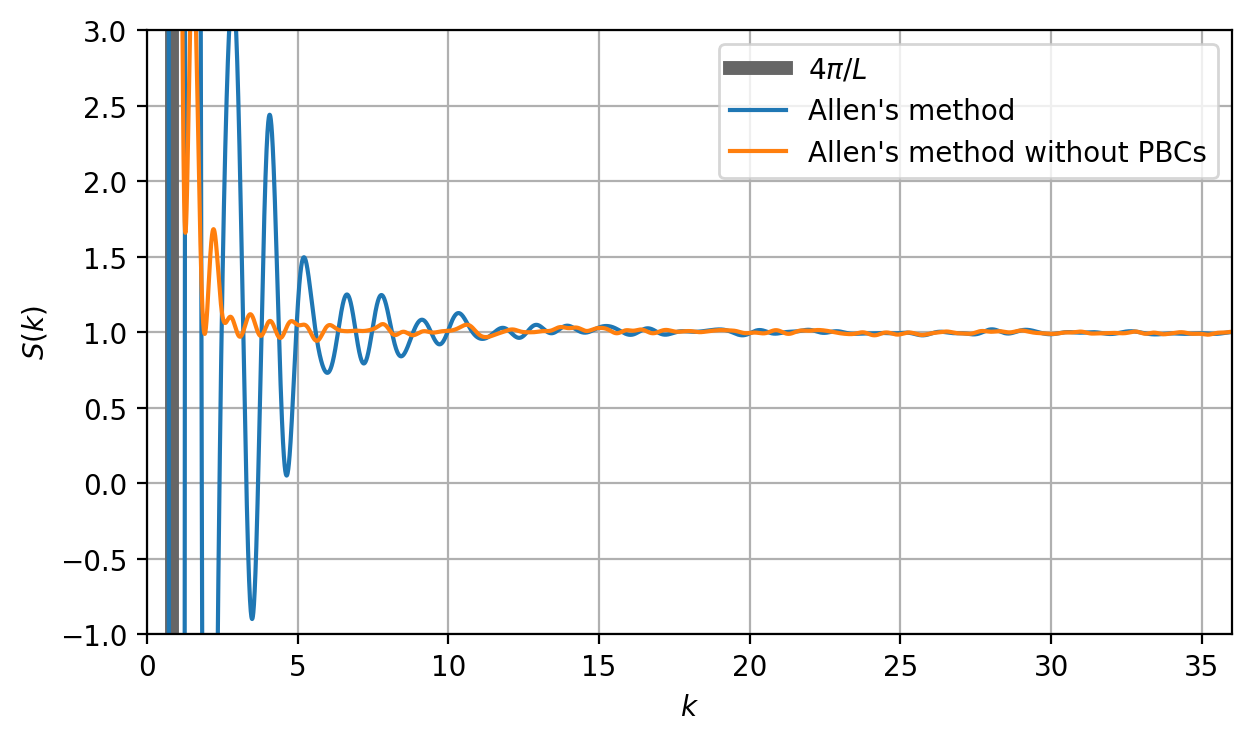

In [72]:
fig, ax = plt.subplots(figsize=(7, 4), dpi=200)
# plt.axvline(2 * np.pi / L, color="#333333", label="$2\pi/L$", linewidth=5)
plt.axvline(4 * np.pi / L, color="#666666", label=r"$4\pi/L$", linewidth=5)
# plt.axvline(8 * np.pi / L, color="#999999", label="$8\pi/L$", linewidth=5)
# plt.plot(Q_rdf, S_rdf, label="RDF Python")
# plt.plot(Q_direct, S_direct, label="Direct Python")
plt.plot(Q_allen, S_allen, label="Allen's method")
plt.plot(Q_allen2, S_allen2, label="Allen's method without PBCs")
# plt.plot(Q_kwang, S_kwang, label="Kwang's method")
# plt.plot(Q_rdf_direct, S_rdf_direct, label="RDF Direct Python")
# plt.plot(sk_rdf.bin_centers, sk_rdf.S_k, label="RDF C++")
# plt.plot(sk_direct.bin_centers, sk_direct.S_k, label="Direct C++")
plt.xlim((0, 36))  # k_max))
plt.ylim((-1, 3))
plt.xlabel("$k$")
plt.ylabel("$S(k)$")
# plt.axvline(4 * np.pi / (0.5 * ), color='k', label='$k_{min} = 4\pi/L$', linewidth=3)
plt.legend()
plt.grid()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4), dpi=200)
k_max = 60

fcc = freud.data.UnitCell.fcc()
for s in [0.1]:
    box, points = fcc.generate_system(6, sigma_noise=s)
    system = (box, points)
    system = freud.AABBQuery.from_system(system)
    with timer("RDF Python"):
        Q_rdf, S_rdf = validate_method(system, bins, k_max, k_min, direct=False)
    with timer("Direct Python"):
        Q_direct, S_direct = validate_method(system, bins, k_max, k_min, direct=True)
    sk_rdf = freud.diffraction.StaticStructureFactor(bins, k_max, k_min, False)
    sk_direct = freud.diffraction.StaticStructureFactor(bins, k_max, k_min, True)
    with timer("Allen no PBC"):
        Q_allen, S_allen = allen_method(system, bins, k_max, k_min, periodic=False)
    with timer("Allen PBC"):
        Q_allen_pbc, S_allen_pbc = allen_method(
            system, bins, k_max, k_min, periodic=True
        )
    with timer("RDF C++"):
        sk_rdf.compute(system)
    with timer("Direct C++"):
        sk_direct.compute(system)
        # 1.4122337
        # 2.5799838
    # plt.plot(Q_rdf, S_rdf, label="RDF Python")
    plt.plot(Q_direct, S_direct, label="Direct Python", linewidth=5)
    # plt.plot(sk_rdf.bin_centers, sk_rdf.S_k, label="RDF C++")
    plt.plot(sk_direct.bin_centers, sk_direct.S_k, label="Direct C++", linewidth=3)
    # plt.plot(Q_allen, S_allen, label="Allen no PBC", linewidth=1)
    plt.plot(Q_allen_pbc, S_allen_pbc, label="Allen w/ PBC", linewidth=1)

plt.axvline(2 * np.pi / np.min(box.L), color="#333333", label=r"$2\pi/L$", linewidth=2)
plt.axvline(4 * np.pi / np.min(box.L), color="#666666", label=r"$4\pi/L$", linewidth=2)
plt.axvline(8 * np.pi / np.min(box.L), color="#999999", label=r"$8\pi/L$", linewidth=2)

plt.title(f"FCC system of {len(points)} particles, $\\sigma={s}$")
plt.xlim((0, k_max))
plt.ylim((-2, 2))
plt.xlabel("$k$")
plt.ylabel("$S(k)$")
# plt.axvline(4 * np.pi / (0.5 * ), color='k', label='$k_{min} = 4\pi/L$', linewidth=3)
plt.legend()
plt.grid()
plt.show()